In [183]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import shutil
import tensorflow as tf

from matplotlib.pyplot import imshow
from PIL import Image

keras = tf.keras

In [170]:
dirname = os.getcwd()
filename = os.path.join(dirname, 'hmnist_28_28_RGB.csv\\hmnist_28_28_RGB.csv')
data = pd.read_csv(filename)

In [171]:
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [96]:
metadata_file = os.path.join(dirname, 'HAM10000_metadata.csv')
metadata = pd.read_csv(metadata_file)
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


## Transfer Learning

In [103]:
# to create folders for each class to sort data for CNN
folders = pd.unique(metadata.dx)
for folder in folders:
    os.mkdir(os.path.join(dirname, 'data', folder))

In [117]:
image_path = os.path.join(dirname, 'HAM10000_images_part_2')
for r, d, files in os.walk(image_path):
    for file in files:
        folder_class = metadata.loc[metadata['image_id'] == file[:-4], 'dx'].iloc[0]
        s = os.path.join(image_path, file)
        d = os.path.join(dirname, 'data', folder_class, file)
        shutil.move(s, d)

In [122]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

image_count = 10015
CLASS_NAMES = folders
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [123]:
train_data_gen = image_generator.flow_from_directory(directory=os.path.join(dirname, 'data'),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 10015 images belonging to 7 classes.


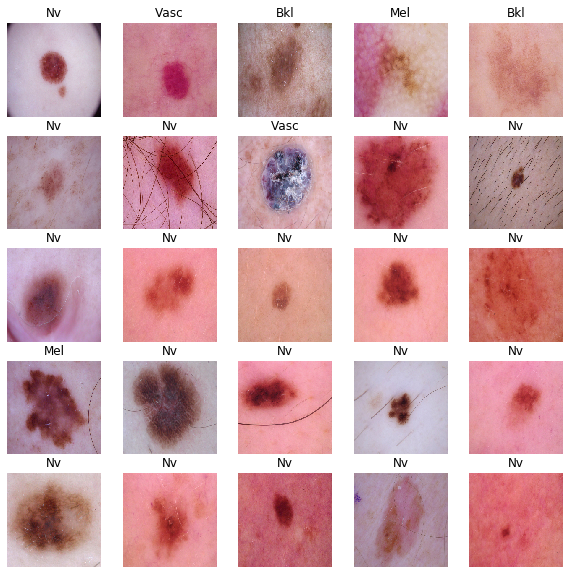

In [124]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')
        
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [125]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [126]:
base_model.trainable = False

In [127]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [128]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1)
])

In [129]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [130]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [131]:
history = model.fit(train_data_gen,
                    epochs=10)

Train for 313 steps
Epoch 1/10
313/313 [==============================] - 1542s 5s/step - loss: 2.1443 - accuracy: 0.7918
Epoch 2/10
313/313 [==============================] - 1561s 5s/step - loss: 2.1017 - accuracy: 0.8459
Epoch 3/10
313/313 [==============================] - 1466s 5s/step - loss: 2.1132 - accuracy: 0.8498
Epoch 4/10
313/313 [==============================] - 1419s 5s/step - loss: 2.0686 - accuracy: 0.8422
Epoch 5/10
313/313 [==============================] - 1419s 5s/step - loss: 2.0518 - accuracy: 0.8400
Epoch 6/10
313/313 [==============================] - 1488s 5s/step - loss: 2.0544 - accuracy: 0.8427
Epoch 7/10
313/313 [==============================] - 1444s 5s/step - loss: 2.0257 - accuracy: 0.8362
Epoch 8/10
313/313 [==============================] - 1526s 5s/step - loss: 2.0186 - accuracy: 0.8415
Epoch 9/10
313/313 [==============================] - 1453s 5s/step - loss: 2.0003 - accuracy: 0.8372
Epoch 10/10
313/313 [==============================] - 1536s 5

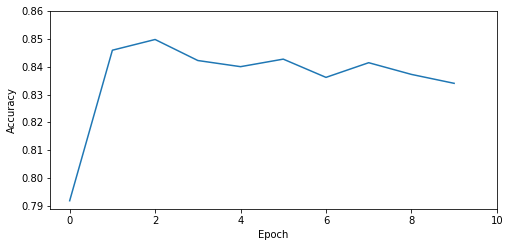

In [162]:
acc = history.history['accuracy']
loss = history.history['loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xlim([min(plt.xlim()),10])
plt.ylim([min(plt.ylim()),0.86])
plt.savefig('accuracy.png')

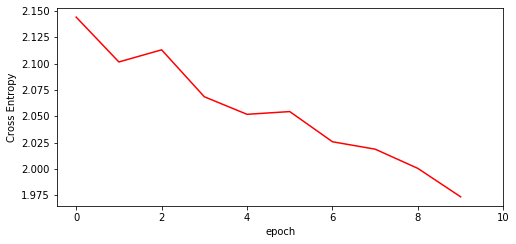

In [178]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(loss, color = 'red')
plt.ylabel('Cross Entropy')
plt.xlabel('epoch')
plt.xlim([min(plt.xlim()),10])
plt.savefig('loss.png')

In [ ]:
model.predict()

In [176]:
import numpy as np
rgbArray = np.zeros((28,28,3), 'uint8')
rgbArray[..., 0] = x[0][0:784].reshape((28,28))
rgbArray[..., 1] = x[0][784:1568].reshape((28,28))
rgbArray[..., 2] = x[0][1568:2352].reshape((28,28))
img = Image.fromarray(rgbArray)
plt.show(img)


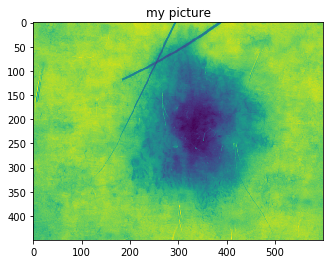

<tf.Tensor: id=60, shape=(160, 160, 3), dtype=float32, numpy=
array([[[128.41406 , 130.52734 , 225.77344 ],
        [134.04688 , 129.9336  , 226.25781 ],
        [139.60938 , 131.22266 , 230.8711  ],
        ...,
        [130.91797 , 132.71875 , 226.74219 ],
        [132.27344 , 132.      , 225.91016 ],
        [136.52734 , 135.58984 , 225.76562 ]],

       [[131.5625  , 131.14453 , 229.46094 ],
        [135.48828 , 134.15625 , 228.6836  ],
        [135.26562 , 129.10938 , 225.79297 ],
        ...,
        [133.3789  , 133.5586  , 227.5586  ],
        [134.625   , 135.64062 , 226.21094 ],
        [133.16797 , 134.5664  , 224.63672 ]],

       [[132.71094 , 131.41797 , 230.0039  ],
        [135.20703 , 131.94922 , 229.8164  ],
        [134.74219 , 132.28906 , 230.7461  ],
        ...,
        [136.97266 , 137.14453 , 228.26562 ],
        [140.0039  , 140.58203 , 230.65625 ],
        [134.98047 , 139.30469 , 227.4375  ]],

       ...,

       [[120.25391 , 121.25391 , 211.78516 ],
      

In [92]:
from matplotlib import pyplot as plt
import cv2
file = os.path.join(dirname, "HAM10000_images_part_1//ISIC_0024306.jpg")
img = cv2.imread(file)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(gray)
plt.title('my picture')
plt.show()
image = tf.cast(img, tf.float32)
tf.image.resize(image, (160, 160))

## PCA For Image

In [197]:
filename = os.path.join(dirname, 'hmnist_28_28_L.csv\\hmnist_28_28_L.csv')
data_l = pd.read_csv(filename)
# Separating out the features
x = data_l.loc[:, data_l.columns != 'label'].values
# Separating out the target
y = data_l.loc[:,['label']].values

# Standardise data 
x1 = StandardScaler().fit_transform(x)

# PCA
pca = PCA(n_components = 784
         )
principalComponents = pca.fit_transform(x1)

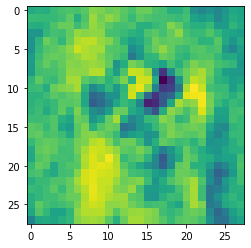

In [192]:
# Visualising Images
data1 = x[0].reshape((28,28))

%matplotlib inline
imshow(np.asarray(data1))

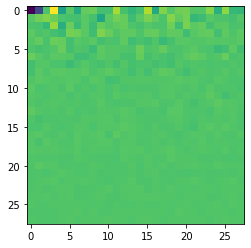

In [198]:
# Visualising Images
data2 = principalComponents[0].reshape((28,28))

%matplotlib inline
imshow(np.asarray(data2))

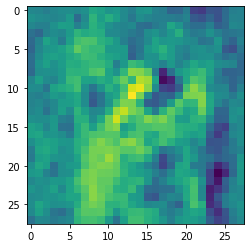

In [17]:
# Visualising Images
data1 = x1[0].reshape((28,28))

%matplotlib inline
imshow(np.asarray(data1))

### Utils

In [36]:
def df_to_ds(df, shuffle_size, batch_size):
    df_copy = df.copy()
    labels = df_copy.pop('label')
    ds = tf.data.Dataset.from_tensor_slices((df_copy.values, labels.values))
    if shuffle_size > 0:
      ds = ds.shuffle(buffer_size = shuffle_size)
    ds = ds.batch(batch_size)
    return ds


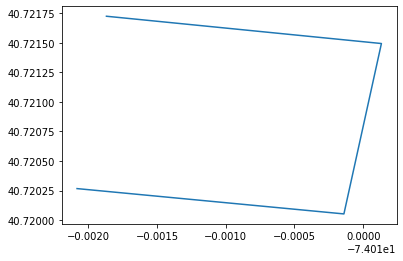

In [214]:
import numpy as np
import matplotlib.pyplot as plt

data =[[-74.011869, 40.7217236], [-74.009867, 40.721493], [-74.010140,40.720053], [-74.012083, 40.720267]]

x = [i[0] for i in data]
y = [i[1] for i in data]

plt.plot(x,y)
# for i in range(0, len(x), 2):
#     plt.plot(x[i:i+2], y[i:i+2], 'ro-')

plt.show()

In [219]:
min(x)

-74.012083